# Preparing Data


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import fastai
from fastai.vision import *
import pandas as pd
import os
from shutil import copyfile

print(os.listdir("../input/aptos2019-blindness-detection"))

['test.csv', 'test_images', 'train.csv', 'sample_submission.csv', 'train_images']


In [3]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x_train = df_train['id_code']
y_train = df_train['diagnosis']

In [4]:
# Creating data into folder format
os.mkdir("../data")
os.mkdir("../data/train")
for i in range(5):
    os.mkdir("../data/train/"+str(i))
def make_img_folder(x, y):
    for img_name ,diagnosis in zip(x,y):
        if diagnosis == 0:
            copyfile('../input/aptos2019-blindness-detection/train_images/{}.png'.format(img_name), '../data/train/0/{}.png'.format(img_name))
        if diagnosis == 1:
            copyfile('../input/aptos2019-blindness-detection/train_images/{}.png'.format(img_name), '../data/train/1/{}.png'.format(img_name))
        if diagnosis == 2:
            copyfile('../input/aptos2019-blindness-detection/train_images/{}.png'.format(img_name), '../data/train/2/{}.png'.format(img_name))
        if diagnosis == 3:
            copyfile('../input/aptos2019-blindness-detection/train_images/{}.png'.format(img_name), '../data/train/3/{}.png'.format(img_name))
        if diagnosis == 4:
            copyfile('../input/aptos2019-blindness-detection/train_images/{}.png'.format(img_name), '../data/train/4/{}.png'.format(img_name))
            
make_img_folder(x_train, y_train)

In [5]:
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/pytorch-pretrained-image-models/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [6]:
np.random.seed(42)
src = (ImageList.from_folder("../data/train")
                .split_by_rand_pct(0.2)
                .label_from_folder())
data = (src.transform(tfms=get_transforms(flip_vert=True, max_warp=0), size=128)
           .databunch(bs=64, path='.').normalize(imagenet_stats))

In [7]:
print(data.classes, data.c)

['0', '1', '2', '3', '4'] 5


In [8]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir=".", callback_fns=ShowGraph)

In [9]:
# learn.lr_find()
# learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.373398,1.211541,0.676230,07:41
1,1.043045,0.707545,0.759563,07:45
2,0.806578,0.623197,0.770492,07:40
3,0.672302,0.548405,0.780055,07:41
4,0.596625,0.541067,0.788251,07:39


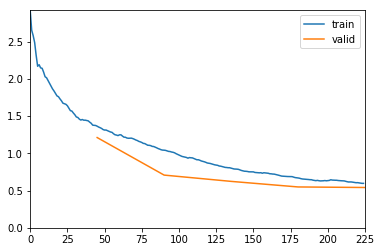

In [10]:
learn.fit_one_cycle(5,3e-3)

In [11]:
learn.save("retino50_128_1")
learn.load("retino50_128_1");

In [12]:
learn.unfreeze()

In [13]:
# learn.lr_find()
# learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.560637,0.536602,0.789617,07:40
1,0.569624,0.541539,0.789617,07:36
2,0.544318,0.528323,0.795082,07:39
3,0.538481,0.531961,0.786885,07:39


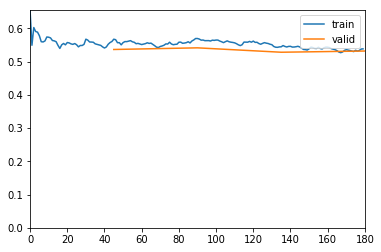

In [14]:
learn.fit_one_cycle(4, max_lr=slice(2e-6,5e-6))

In [15]:
learn.save("retino50_128_2")

## Progressive Resizing

In [16]:
data = (src.transform(tfms=get_transforms(flip_vert=True, max_warp=0), size=256)
           .databunch(bs=64, path='.').normalize(imagenet_stats))

In [17]:
learn.data = data

In [18]:
# learn.lr_find()
# learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.690344,2.968366,0.583333,08:23
1,0.704935,2.911403,0.670765,08:16
2,0.672536,0.884385,0.734973,08:24
3,0.618655,0.590722,0.775956,08:27
4,0.559675,0.532676,0.799180,08:20


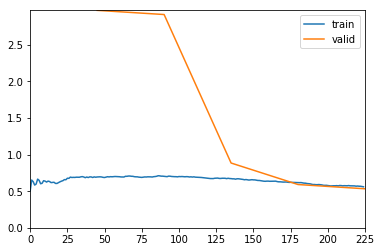

In [19]:
learn.fit_one_cycle(5, 3e-3)

In [20]:
learn.save("retino50_256_1")
learn.load("retino50_256_1");

In [21]:
learn.unfreeze()

In [22]:
# learn.lr_find()
# learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.528081,0.530408,0.799180,08:26
1,0.507760,0.525977,0.801913,08:27
2,0.513463,0.528626,0.800546,08:26
3,0.512051,0.526377,0.799180,08:24
4,0.503190,0.524630,0.804645,08:28


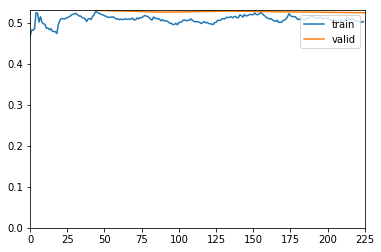

In [23]:
learn.fit_one_cycle(5, slice(1e-6))

In [24]:
learn.save("retino50_256_2")

### Predictions

In [25]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [26]:
learn.data.add_test(ImageList.from_df(sample_df,'../input/aptos2019-blindness-detection/',folder='test_images',suffix='.png'))

In [27]:
preds,y = learn.get_preds(DatasetType.Test)

In [28]:
sample_df.diagnosis = preds.argmax(1)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,1


In [29]:
sample_df.to_csv('submission.csv',index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 